KDE-related plots: tas on days with (without) melt
===

Global module imports
---

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.text import Text
from timeit import default_timer as timer
from itertools import izip

%load_ext autoreload
%autoreload 2
from model import Model
from GCNet import GCNet
from plotUtils import PlotUtils

pd.options.mode.chained_assignment = None

Global data
---

In [2]:
yr1a = "1986"
yr2a = "2015"

# yr1a = "1996"
# yr2a = "2005"

yrsHist = yr1a+"-"+yr2a

# Mlsm = Model("wrf_geog.nc", "landmask.nc")
# lsm2d = Mlsm.loadData( "LANDMASK", True )
# lsm = lsm2d.values.reshape(-1,).tolist()

# Morog = Model("wrf_geog.nc", "lat_lon_orog.nc")
# orog2d = Morog.loadData( "orog", True )
# orog = orog2d.values.reshape(-1,).tolist()

linewidth = 4

Aglobal = GCNet("site_info.nc", None)
Aglobal.loadMeta()
awsNames = Aglobal.getNames()

bw = 0.4
site = None

# save or load variables to/from files
saveData = 0
restoreData = 1
if restoreData:
    saveData = 0  # avoid re-saving data if it was restored in this run

# saveList: a list of [varname,is-it-a-list] pairs
saveList = [ ['tasm',1], ['tasnm',1], ['mltm',1], ['mltnm',1], \
             ['xs',0], ['XmNrm',0], ['XnmNrm',0], ['Pm',0], ['Pnm',0], ['Z',0] ]

Function: Remove masked elements
---

In [3]:
def compress(data, selectors):
    # compress('ABCDEF', [1,0,1,0,1,1]) --> A C E F
    return (d for d, s in izip(data, selectors) if s)

Function: Load and prepare a data file
---

In [4]:
def loadData( var, model, period, mms, yrs, suff, mask, site = None ):
    # Load data, convert to 1-d
    
    if model == "melt":
        modelDir = "/Users/dbr/Documents/gismelt/mote_sfc_melt"
        if site is None:
            modelFN = "Mote_"+yrs+"_"+mms+".nc"
        else:
            modelFN = "wrf_mote_melt_closest_"+yrs+"_"+mms+".nc"
    if model == "erai":
        if site is None:
            modelDir = "/Volumes/sbp1/model/pwrf/gis_erai/"+period+"/wrf/postproc/tas"
            modelFN = var+"_wrf_erai_"+yrs+"_"+mms+"_d.nc"
        else:
            modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_erai"
            modelFN = "wrf_erai_"+var+"_closest_"+yrs+"_"+mms+".nc"
    if model == "cesmle":
        if site is None:
            modelDir = "/Volumes/sbp1/model/pwrf/gis_cesmle/"+period+"/wrf/postproc/tas/ens"
            if suff is None:
                modelFN = var+"_wrf_cesmle_ens_"+yrs+"_"+mms+"_d.nc"
            else:
                modelFN = var+"_wrf_cesmle_ens_"+yrs+"_"+mms+"_d_"+suff+".nc"
        else:
            modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_cesmle"
            if suff is None:
                modelFN = "wrf_cesmle_"+var+"_closest_"+yrs+"_"+mms+".nc"
            else:
                modelFN = "wrf_cesmle_"+var+"_closest_"+yrs+"_"+mms+"_"+suff+".nc"

    if model == "cesmlw":
        if site is None:
            modelDir = "/Volumes/sbp1/model/pwrf/gis_cesmlw/"+period+"/wrf/postproc/tas/ens"
            if suff is None:
                modelFN = var+"_wrf_cesmlw_ens_"+yrs+"_"+mms+"_d.nc"
            else:
                modelFN = var+"_wrf_cesmlw_ens_"+yrs+"_"+mms+"_d_"+suff+".nc"
        else:
            modelDir = "/Users/dbr/Documents/gismelt/models_vs_obs/gis_cesmlw"
            if suff is None:
                modelFN = "wrf_cesmlw_"+var+"_closest_"+yrs+"_"+mms+".nc"
            else:
                modelFN = "wrf_cesmlw_"+var+"_closest_"+yrs+"_"+mms+"_"+suff+".nc"
        
    if site is None:
        M = Model("wrf_geog.nc", modelDir+"/"+modelFN)
        X = M.loadData( var, True, -2 )
    else:
        print modelFN
        A = GCNet("site_info.nc", modelDir+"/"+modelFN)
        A.loadMeta()
        M = A.loadData( var, True )
        if site == "All":
            X = M
        else:
            X = M[site]

    X1d = X.values.reshape(-1,).tolist()
#     print "X1d: "+str(len(X1d))+" points, min = "+str(min(X1d))
    
    if mask is None:
        X1dMask = X1d
    else:
        maskVar = mask[0]
        if maskVar == "lsm":  # masking against landsea mask
            X1dMask = list( compress( X1d, lsm ) )
        else:
            if maskVar == "orog":  # masking against orography
                X1dLSM = np.array( list( compress( X1d, lsm )))
                orogLSM = np.array( list( compress( orog, lsm )))
                maskElev = mask[1]
                if maskElev > 0:
                    msk = np.where( orogLSM > abs(maskElev) )[0]
                    X1dMask = X1dLSM[ msk ].tolist()
#                     X1dMask = X1dLSM[ np.where( orogLSM > maskElev ) ].tolist()
                else:
                    msk = np.where( orogLSM < abs(maskElev) )[0]
                    X1dMask = X1dLSM[ msk ].tolist()
#                     X1dMask = X1dLSM[ np.where( orogLSM < abs(maskElev) ) ].tolist()
            else:
                print "Mask variable not recognized"
                return None
    
    return X1dMask

Function: Make Kernel Density Estimate plot
---

In [5]:
def plotData( X, bw = None, color = 'b' ):
    if bw is None:
        bw = 0.2
    sns.kdeplot( X, cut=0, bw=bw, linewidth=linewidth, color=color, )

Function: Mask elements
---

In [6]:
def maskData( X, Y, mask ):
    mskix = np.where(np.array(Y) == mask )[0]
    msklist = np.zeros(len(Y))
    if len(mskix) > 0:
        msklist[mskix] = 1
    msklist = msklist.tolist()
    X2 = list( compress( X, msklist ))
    Y2 = list( compress( Y, msklist ))
    return ( X2, Y2 )

Function: Drop NaN elements
---

In [7]:
def dropNaN( X, Y, theNaN = None ):
    if theNaN is None:
        nanix = np.where(np.isnan(np.array(Y)))[0]
    else:
        if theNaN > 0:
            nanix = np.where(np.array(Y) > theNaN )[0]
        else:
            nanix = np.where(np.array(Y) < theNaN )[0]
    nanlist = np.ones(len(Y))
    nanlist[nanix] = 0
    nanlist = nanlist.tolist()
    X2 = list( compress( X, nanlist ))
    Y2 = list( compress( Y, nanlist ))
    return ( X2, Y2 )

Function: Add a legend
---

In [8]:
def addLegend( ax, loc, legText = None):
    if legText is None:
        lbls = ['Melt days','No-melt days']
    else:
        lbls = legText
    if len( legText ) > 1:
        h = ax.lines[-2:]
    else:
        h = ax.lines
    ax.legend(handles = h, \
              labels = lbls, \
              loc = loc, \
              fancybox = True, \
              edgecolor = 'black', \
              frameon = True, \
              fontsize = 14);

Function: Mask elements below a certain value
---

In [9]:
def maskDataBelow( X, mask ):
    X2 = np.copy( X )
    mskix = np.where(X < mask)[0]
    if len(mskix) > 0:
        X2[mskix] = np.nan
#         X2[mskix] = 0
    return ( X2, mskix )

Function: Clean up time series
---

In [10]:
def cleanTimeSeries( X, Y, debug = None ):
    # clean time series by testing against values in either X or Y
    
    # drop days where X data is _FillValue
    Y2, X2 = dropNaN( Y, X, 1.e3 )
    if not debug is None:
        print "Orig len: "+str(len(X))+", X FillValue-filtered len: "+str(len(X2))

    # drop days where X data is "nan"
    Y3, X3 = dropNaN( Y2, X2 )
    if not debug is None:
        print "Orig len: "+str(len(X2))+", X NaN-filtered len: "+str(len(X3))

    # drop days where Y data is "NaN"
    X4, Y4 = dropNaN( X3, Y3, -1. )
    if not debug is None:
        print "Orig len: "+str(len(X3))+", Y NaN-filtered len: "+str(len(X4))

    return (X4, Y4)

Function: Annotate plot
---

In [11]:
def annotatePlot( title, xlabel, ylabel, legend, legloc ):
    ax = plt.gca()
    plt.title( title, fontsize=18 );
    plt.xlabel( xlabel, fontsize=16 );
    plt.ylabel( ylabel, fontsize=16 );
    if legloc is None:
        legloc = 'best'
    addLegend( ax, legloc, legend )
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)

Function: convert KDE to transition function
---

In [12]:
def transitionFN( xs, Xm, Xnm, smthIX = 20 ):
    
    # copy input vars
    Xm2 = np.copy(Xm)
    Xnm2 = np.copy(Xnm)
    
    # find maximum values
    ixXm = np.argmax(Xm)
    ixXnm = np.argmax(Xnm)

    # set pieces of each var outside overlap to nan
    Xm2[0:ixXnm] = np.nan
    Xm2[(ixXm+1):] = np.nan
    Xnm2[(ixXm+1):] = np.nan
    Xnm2[0:ixXnm] = np.nan

    # calculate P(melt)
    Pm = Xm2 / ( Xm2 + Xnm2 )
    minPm = Pm[ixXnm]
    maxPm = Pm[ixXm]
    
    # adjusted indices
    ixXmAdj  = ixXm + smthIX
#     print "Unadjusted ixXmAdj", ixXmAdj
    if ixXmAdj >= len( Xm ):
        ixXmAdj = len( Xm ) - 1
#         print "Adjusted ixXmAdj", ixXmAdj
    ixXnmAdj = ixXnm - smthIX
    if ixXnmAdj < 0:
        ixXnmAdj = 0
    
    # smooth the part between min/max and 0/1
    
    # lhs
    Pm[0:ixXnmAdj] = 0
    infill = np.linspace(0, minPm, num = smthIX)
    try:
        Pm[ixXnmAdj:ixXnm] = infill
    except Exception, error:
        print "fn: try 1 failed", error
         
    # rhs
    Pm[ixXmAdj:] = 1
    rhsIX = range( ixXm, ixXmAdj )
    rhsSmthIX = smthIX
    if len(rhsIX) < rhsSmthIX:
        rhsSmthIX = len(rhsIX)
    infill = np.linspace(maxPm, 1, num = rhsSmthIX)
    try:
        Pm[rhsIX] = infill
    except Exception, error:
        print "fn: try 2 failed", error

    # make in-between linear
    lhsIX = range( ixXnmAdj, ixXmAdj )
#     print "lhsix",lhsIX
#     npts = (ixXm + smthIX) - (ixXnm - smthIX)
    npts = len( lhsIX )
    infill = np.linspace(0, 1, num = npts)
#     print "infill", len(infill)
    try:
        Pm[lhsIX] = infill
    except Exception, error:
        print "fn: try 3 failed", error
    
    # likelihood of no-melt = 1 - P(melt)
    Pnm = 1 - Pm
    
    # transition point values
    xLwr = round( xs[ixXnmAdj],1 )
    xUpr = round( xs[ixXmAdj],1 )

    # calculate linear regression parameters
    m = (1. - 0.) / (xUpr - xLwr)
    b = 1. - m*xUpr
    
    return Pm, Pnm, xLwr, xUpr, m, b

Function:  Save state variables to a file
---

In [13]:
def saveState( ofn ):
    print "Saving state variables to "+ofn+".npz"

    kwDict = {}
    
    # add vars to dict
    for v,f in saveList:
#         print v
        if type(v) is list:
            kwDict[v] = eval("np.array("+v+")")
        else:
            kwDict[v] = eval(v)
    
    # save all the vars to the file
    np.savez_compressed( ofn, **kwDict )

Function: Restore state variables from file
---

In [14]:
def restoreState( ifn ):
    global dataStore

    print "Restoring state variables from save file "+ifn+".npz"
    dataStore = np.load(ifn+".npz")
    
    for v,f in saveList:
#         print v
        if f:
            exec( v+"=dataStore['"+v+"'].tolist()", globals() )
        else:
            exec( v+"=dataStore['"+v+"']", globals() )

Setup plotting
---

In [15]:
plotStr = "amsmelt"
plotOptions = { "saveFigure": False }
# plotOptions = { "saveFigure": True }

P = PlotUtils( plotOptions )

Look only at AWS sites
===

tas
----

In [16]:
npFN = 'tas_aws'
if restoreData:
    restoreState( npFN )
    print "Melt: "+str(len(tasm)), str(len(mltm))
    print "No-melt: "+str(len(tasnm)), str(len(tasnm))

# mm = 6
# mm = 7
# mm = 8
mm = "JJA"

period = "historical"
suff = None
mask = None
site = "All"
# site = "Swiss Camp"
# site = "Humboldt"
# site = "GITS"
# site = "Saddle"
minMeltPts = 10

try:
    mms = "%02d" % mm
except TypeError:
    mms = mm

tStart = timer()
if not restoreData:
    mlt = loadData( "greenland_surface_melt", "melt", period, mms, yrsHist, suff, mask, site )
    tas = loadData( "tas", "erai", period, mms, yrsHist, suff, mask, site )
    print "Data series: "+str(len(mlt))+", "+str(len(tas))+", max(tas)="+str(max(tas))

    # drop FillValues, NaNs
    tas, mlt = cleanTimeSeries( tas, mlt, True )

    # stratify into melt/no-melt using melt data
    tasm, mltm = maskData( tas, mlt, 1 )
    print "Melt: "+str(len(tasm)), str(len(mltm))

    tasnm, mltnm = maskData( tas, mlt, 0 )
    print "No-melt: "+str(len(tasnm)), str(len(tasnm))

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

Restoring state variables from save file tas_aws.npz
Melt: 11560 11560
No-melt: 43996 43996
Elapsed: 0 seconds


Elapsed: 0 seconds


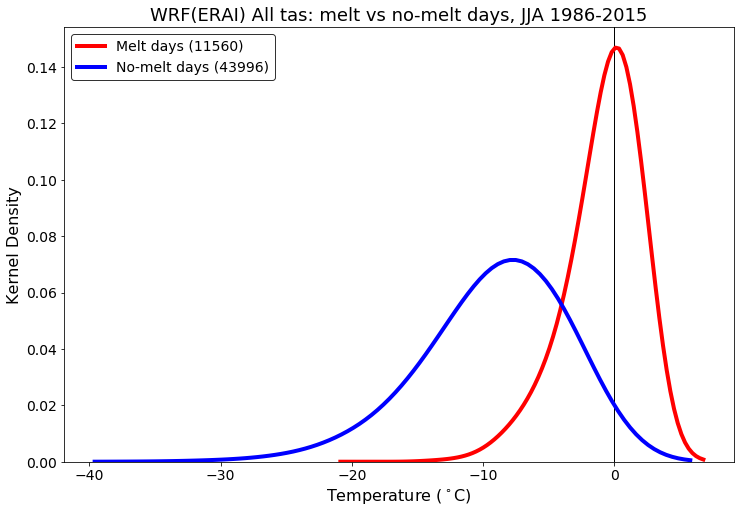

In [17]:
# make KDE plot
tStart = timer()
fig, ax = plt.subplots( figsize=(12,8))
if len(tasm) > minMeltPts:
    plotData( tasm, bw, 'r' )
    plotData( tasnm, bw, 'b' )

    xlabel = 'Temperature ($^\circ$C)'
    ylabel = 'Kernel Density'
    if not site is None:
        title = "WRF(ERAI) "+site+" tas: melt vs no-melt days, "+mms+" "+yrsHist
    else:
        title = "WRF(ERAI) tas: melt vs no-melt days, "+mms+" "+yrsHist
    legend = [ 'Melt days ('+str(len(tasm))+')', 'No-melt days ('+str(len(tasnm))+')' ]
    annotatePlot( title, xlabel, ylabel, legend, None )

    xmin, xmax = ax.get_xlim();
else:
    print "Data series too short!"

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

P.saveFigure2( "wrf_erai_tas_aws_kde_"+yrsHist+"_"+mms )

Create transition functions
----

In [18]:
# generate KDE's directly
tStart = timer()
if not restoreData:
    xs = np.arange(min(tas), max(tas), 0.1)

    Km = stats.gaussian_kde( tasm, bw_method=bw )
    Xm = np.array(Km(xs))

    Knm = stats.gaussian_kde( tasnm, bw_method=bw )
    Xnm = np.array(Knm(xs))

    # normalized versions to plot with the derived transition functions
    Xscale = max(max(Xm),max(Xnm))
    XmNrm = Xm / Xscale
    XnmNrm = Xnm / Xscale

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

Elapsed: 0 seconds


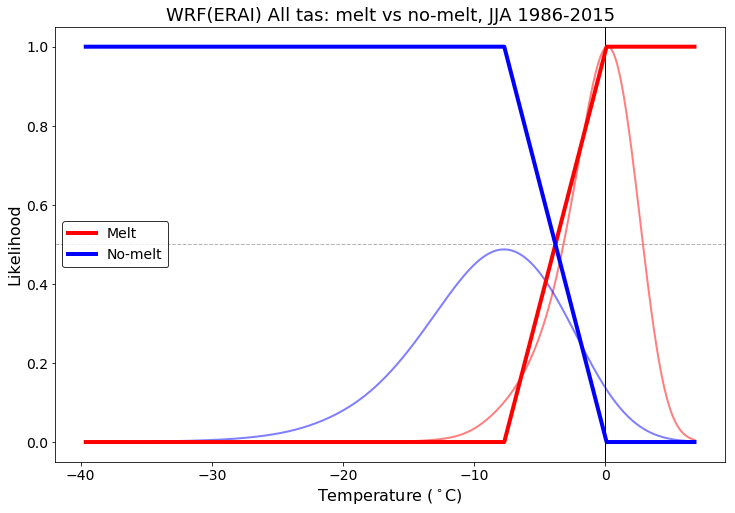

In [19]:
# make plot of transition functions
if not restoreData:
    Pm, Pnm, xLwr, xUpr, m, b = transitionFN( xs, Xm, Xnm, 0 )
    print "Lower break = %.1f, Upper break = %.1f" % ( xLwr, xUpr )
    print "slope = %.2f, intercept = %.2f" % ( m, b )

# xMid = (xUpr + xLwr) / 2.
# yMid = m*xMid + b
# print xMid, yMid

fig, ax = plt.subplots( figsize=(12,8))

plt.plot( xs, XmNrm,  color = 'r', linewidth = linewidth/2, alpha = 0.5 )
plt.plot( xs, XnmNrm, color = 'b', linewidth = linewidth/2, alpha = 0.5 )

plt.plot(xs, Pm, color='r', linewidth = linewidth)
plt.plot(xs, Pnm, color='b',linewidth = linewidth)
# plt.plot( xMid, yMid, 'ro', markersize = 20)

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood'
if not site is None:
    title = "WRF(ERAI) "+site+" tas: melt vs no-melt, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) tas: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt', 'No-melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

# ax.set_xlim( xmin, xmax );

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees
plt.axhline(y=0.5, linewidth=1, color='0.7', linestyle='--', zorder = 0.1);  # show pCrit (default=0.5)

P.saveFigure2( "wrf_erai_tas_aws_kde_trans_"+yrsHist+"_"+mms )

Simple probability transition curve
---

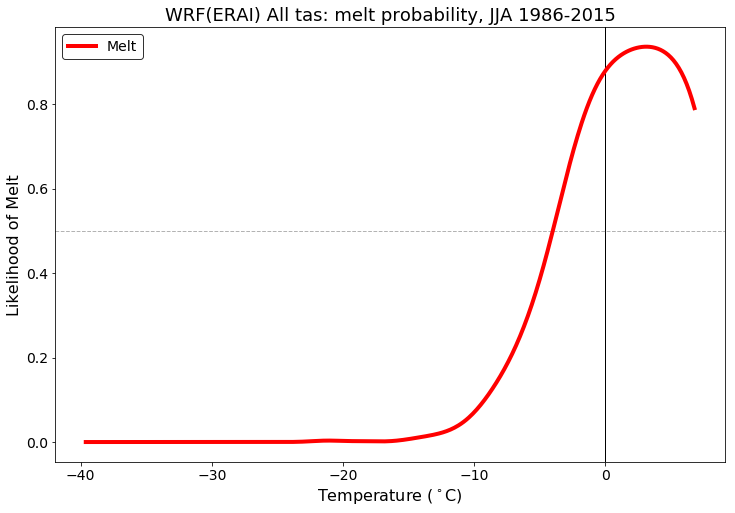

In [20]:
if not restoreData:
    Xsum = XmNrm + XnmNrm
    Z = XmNrm / Xsum # normalized fraction of melt likelihood

fig, ax = plt.subplots( figsize=(12,8))
plt.plot(xs, Z, color='r', linewidth = linewidth)
xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood of Melt'
if not site is None:
    title = "WRF(ERAI) "+site+" tas: melt probability, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) tas: melt probability, "+mms+" "+yrsHist
legend = [ 'Melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees
plt.axhline(y=0.5, linewidth=1, color='0.7', linestyle='--', zorder = 0.1);  # show pCrit (default=0.5)

In [21]:
if saveData:
    saveState( npFN )
else:
    print "Not saving state variables"

Not saving state variables


tasmax
----

In [22]:
npFN = 'tasmax_aws'
if restoreData:
    restoreState( npFN )
    print "Melt: "+str(len(tasm)), str(len(mltm))
    print "No-melt: "+str(len(tasnm)), str(len(tasnm))

# mm = 6
# mm = 7
# mm = 8
# mm = "JJA"

period = "historical"
suff = None
mask = None
site = "All"
# site = "Swiss Camp"
# site = "Humboldt"
# site = "GITS"
# site = "Saddle"
minMeltPts = 10

try:
    mms = "%02d" % mm
except TypeError:
    mms = mm

tStart = timer()
if not restoreData:
    mlt = loadData( "greenland_surface_melt", "melt", period, mms, yrsHist, suff, mask, site )
    tasmax = loadData( "tasmax", "erai", period, mms, yrsHist, suff, mask, site )
    print "Data series: "+str(len(mlt))+", "+str(len(tasmax))+", max(tasmax)="+str(max(tasmax))

    # drop FillValues, NaNs
    tasmax, mlt = cleanTimeSeries( tasmax, mlt, True )

    # stratify into melt/no-melt using melt data
    tasm, mltm = maskData( tasmax, mlt, 1 )
    print "Melt: "+str(len(tasm)), str(len(mltm))

    tasnm, mltnm = maskData( tasmax, mlt, 0 )
    print "No-melt: "+str(len(tasnm)), str(len(tasnm))

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

Restoring state variables from save file tasmax_aws.npz
Melt: 11560 11560
No-melt: 43996 43996
Elapsed: 0 seconds


Elapsed: 0 seconds


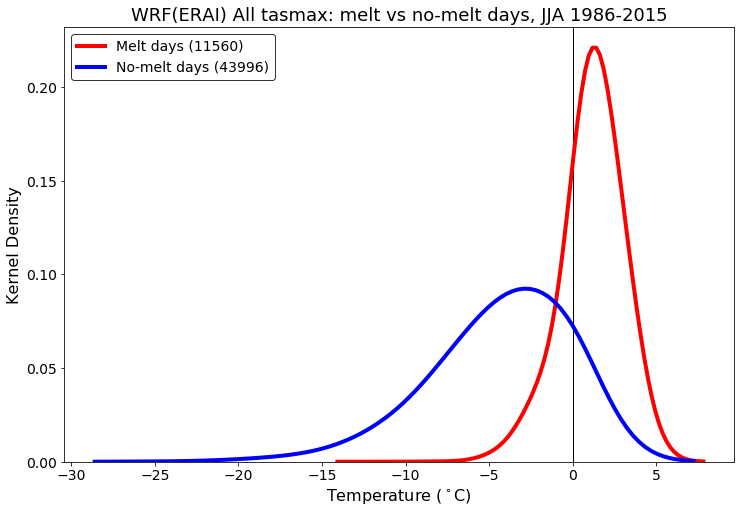

In [23]:
# make KDE plot
tStart = timer()
fig, ax = plt.subplots( figsize=(12,8))
if len(tasm) > minMeltPts:
    plotData( tasm, bw, 'r' )
    plotData( tasnm, bw, 'b' )

    xlabel = 'Temperature ($^\circ$C)'
    ylabel = 'Kernel Density'
    if not site is None:
        title = "WRF(ERAI) "+site+" tasmax: melt vs no-melt days, "+mms+" "+yrsHist
    else:
        title = "WRF(ERAI) tasmax: melt vs no-melt days, "+mms+" "+yrsHist
    legend = [ 'Melt days ('+str(len(tasm))+')', 'No-melt days ('+str(len(tasnm))+')' ]
    annotatePlot( title, xlabel, ylabel, legend, None )

    xmin, xmax = ax.get_xlim();
else:
    print "Data series too short!"
    
plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

P.saveFigure2( "wrf_erai_tasmax_aws_kde_"+yrsHist+"_"+mms )

Create transition functions
----

In [24]:
# generate KDE's directly
tStart = timer()
if not restoreData:
    xs = np.arange(min(tasmax), max(tasmax), 0.1)
    Km = stats.gaussian_kde( tasm, bw_method=bw )
    Xm = np.array(Km(xs))
    Knm = stats.gaussian_kde( tasnm, bw_method=bw )
    Xnm = np.array(Knm(xs))

    # normalized versions to plot with the derived transition functions
    Xscale = max(max(Xm),max(Xnm))
    XmNrm = Xm / Xscale
    XnmNrm = Xnm / Xscale

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

Elapsed: 0 seconds


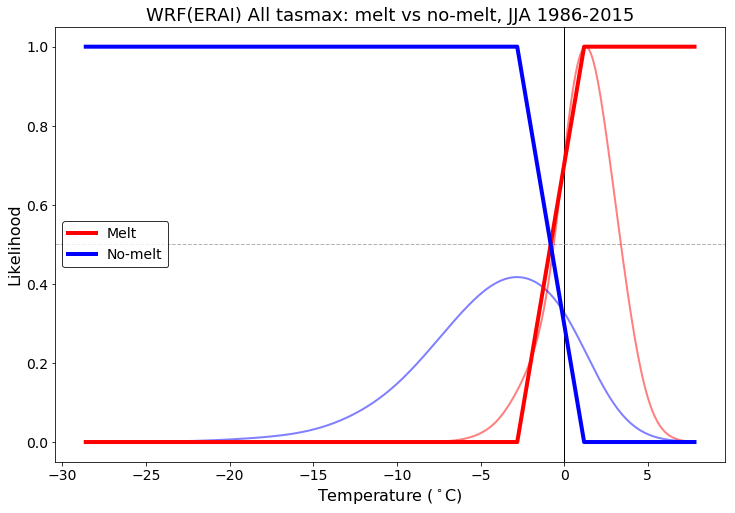

In [25]:
# make plot of transition functions
if not restoreData:
    Pm, Pnm, xLwr, xUpr, m, b = transitionFN( xs, Xm, Xnm, 0 )
    print "Lower break = %.1f, Upper break = %.1f" % ( xLwr, xUpr )
    print "slope = %.2f, intercept = %.2f" % ( m, b )

# xMid = (xUpr + xLwr) / 2.
# yMid = m*xMid + b
# print xMid, yMid

fig, ax = plt.subplots( figsize=(12,8))

plt.plot( xs, XmNrm,  color = 'r', linewidth = linewidth/2, alpha = 0.5 )
plt.plot( xs, XnmNrm, color = 'b', linewidth = linewidth/2, alpha = 0.5 )

plt.plot(xs, Pm, color='r', linewidth = linewidth)
plt.plot(xs, Pnm, color='b',linewidth = linewidth)
# plt.plot( xMid, yMid, 'ro', markersize = 20)

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood'
if not site is None:
    title = "WRF(ERAI) "+site+" tasmax: melt vs no-melt, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) tasmax: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt', 'No-melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

# ax.set_xlim( xmin, xmax );

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees
plt.axhline(y=0.5, linewidth=1, color='0.7', linestyle='--', zorder = 0.1);  # show pCrit (default=0.5)

P.saveFigure2( "wrf_erai_tasmax_aws_kde_trans"+yrsHist+"_"+mms )

Simple probability transition curve
---

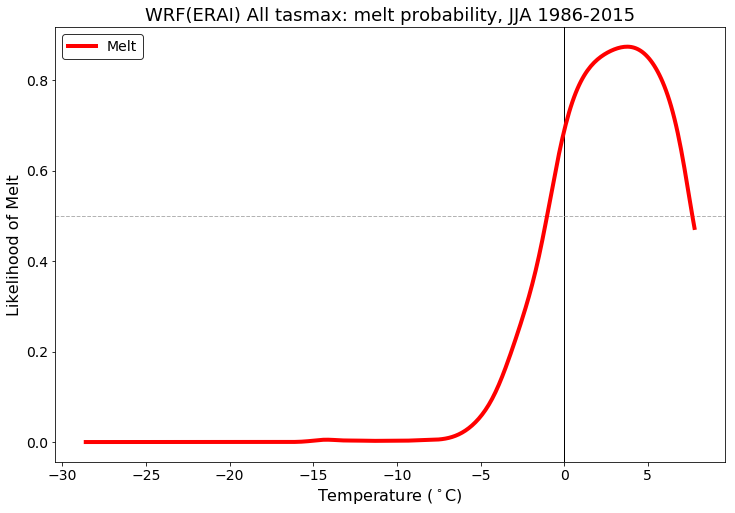

In [26]:
if not restoreData:
    Xsum = XmNrm + XnmNrm
    Z = XmNrm / Xsum   # normalized fraction of melt likelihood

fig, ax = plt.subplots( figsize=(12,8))
plt.plot(xs, Z, color='r', linewidth = linewidth)
xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood of Melt'
if not site is None:
    title = "WRF(ERAI) "+site+" tasmax: melt probability, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) tasmax: melt probability, "+mms+" "+yrsHist
legend = [ 'Melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees
plt.axhline(y=0.5, linewidth=1, color='0.7', linestyle='--', zorder = 0.1);  # show pCrit (default=0.5)

In [27]:
if saveData:
    saveState( npFN )
else:
    print "Not saving state variables"

Not saving state variables


Look at ALL grid points (Slow!)
==

tas
----

In [28]:
npFN = 'tas_grid'
tStart = timer()
if restoreData:
    restoreState( npFN )
    print "Melt: "+str(len(tasm)), str(len(mltm))
    print "No-melt: "+str(len(tasnm)), str(len(tasnm))

# mm = 6
# mm = 7
# mm = 8
# mm = "JJA"

period = "historical"
suff = None
mask = None
site = None  # ALL grid points
minMeltPts = 10

try:
    mms = "%02d" % mm
except TypeError:
    mms = mm

if not restoreData:
    mlt = loadData( "greenland_surface_melt", "melt", period, mms, yrsHist, suff, mask, site )
    tas = loadData( "tas", "erai", period, mms, yrsHist, suff, mask, site )
    print "Data series: "+str(len(mlt))+", "+str(len(tas))

    # drop FillValues, NaNs
    tas, mlt = cleanTimeSeries( tas, mlt, True )

    # stratify into melt/no-melt using melt data
    tasm, mltm = maskData( tas, mlt, 1 )
    print "Melt: "+str(len(tasm)), str(len(mltm))

    tasnm, mltnm = maskData( tas, mlt, 0 )
    print "No-melt: "+str(len(tasnm)), str(len(tasnm))

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

Restoring state variables from save file tas_grid.npz
Melt: 3723631 3723631
No-melt: 16970341 16970341
Elapsed: 1 seconds


Elapsed: 58 seconds


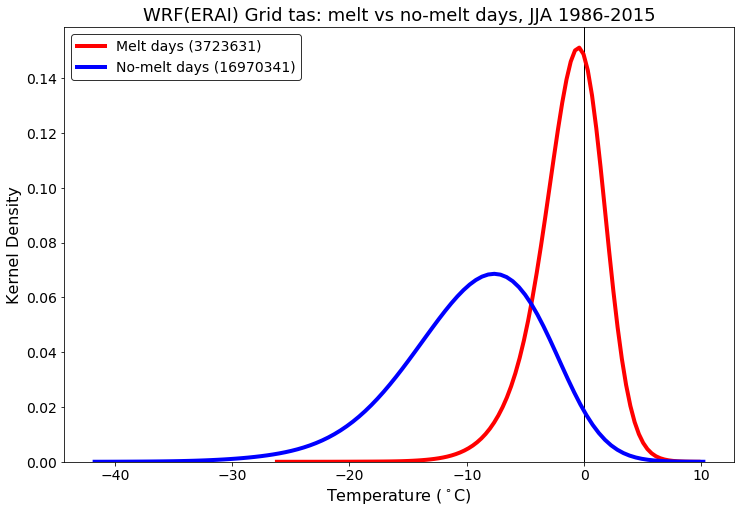

In [29]:
# make KDE plot
tStart = timer()
fig, ax = plt.subplots( figsize=(12,8))
plotData( tasm, bw, 'r' )
plotData( tasnm, bw, 'b' )

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Kernel Density'
if not site is None:
    title = "WRF(ERAI) "+site+" tas: melt vs no-melt days, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) Grid tas: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt days ('+str(len(tasm))+')', 'No-melt days ('+str(len(tasnm))+')' ]
annotatePlot( title, xlabel, ylabel, legend, None )
   
xmin, xmax = ax.get_xlim();

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

P.saveFigure2( "wrf_erai_tas_grid_kde_"+yrsHist+"_"+mms )

Create transition functions
----

In [30]:
# generate KDE's directly
tStart = timer()
if not restoreData:
    xs = np.arange(min(tas), max(tas), 0.1)
    Km = stats.gaussian_kde( tasm, bw_method=bw )
    Xm = np.array(Km(xs))
    Knm = stats.gaussian_kde( tasnm, bw_method=bw )
    Xnm = np.array(Knm(xs))

    # normalized versions to plot with the derived transition functions
    Xscale = max(max(Xm),max(Xnm))
    XmNrm = Xm / Xscale
    XnmNrm = Xnm / Xscale

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

Elapsed: 0 seconds


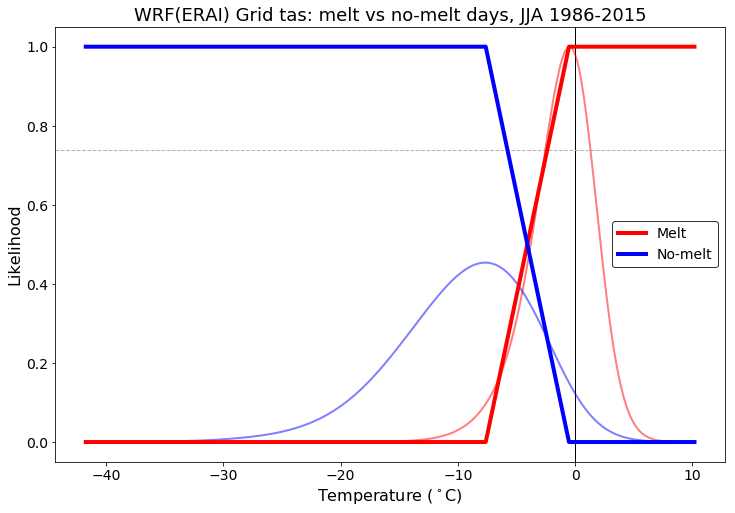

In [31]:
# make plot of transition functions
if not restoreData:
    Pm, Pnm, xLwr, xUpr, m, b = transitionFN( xs, Xm, Xnm, 0 )
    print "Lower break = %.1f, Upper break = %.1f" % ( xLwr, xUpr )
    print "slope = %.2f, intercept = %.2f" % ( m, b )

# xMid = (xUpr + xLwr) / 2.
# yMid = m*xMid + b
# print xMid, yMid

fig, ax = plt.subplots( figsize=(12,8))

plt.plot( xs, XmNrm,  color = 'r', linewidth = linewidth/2, alpha = 0.5 )
plt.plot( xs, XnmNrm, color = 'b', linewidth = linewidth/2, alpha = 0.5 )

plt.plot(xs, Pm, color='r', linewidth = linewidth)
plt.plot(xs, Pnm, color='b', linewidth = linewidth)
# plt.plot( xMid, yMid, 'ro', markersize = 20)

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood'
if not site is None:
    title = "WRF(ERAI) "+site+" tas: melt vs no-melt, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) Grid tas: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt', 'No-melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

# xmin, xmax = ax.get_xlim();
# ax.set_xlim( xmin, xmax );
# ax.set_xlim(-7,3)

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees
plt.axhline(y=0.738, linewidth=1, color='0.7', linestyle='--', zorder = 0.1);  # show pCrit(grid)

P.saveFigure2( "wrf_erai_tas_grid_kde_trans_"+yrsHist+"_"+mms )

Simple probability transition curve
---

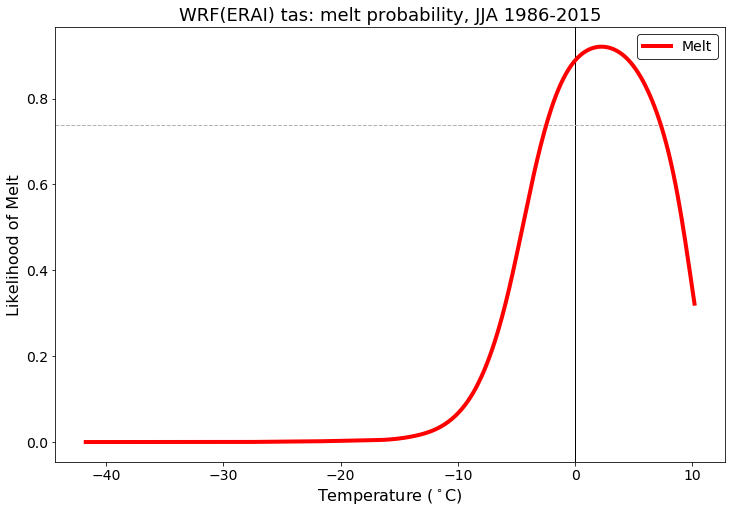

In [32]:
if not restoreData:
    Xsum = XmNrm + XnmNrm
    Z = XmNrm / Xsum # normalized fraction of melt likelihood

fig, ax = plt.subplots( figsize=(12,8))
plt.plot(xs, Z, color='r', linewidth = linewidth)
xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood of Melt'
if not site is None:
    title = "WRF(ERAI) "+site+" tas: melt probability, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) tas: melt probability, "+mms+" "+yrsHist
legend = [ 'Melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees
plt.axhline(y=0.738, linewidth=1, color='0.7', linestyle='--', zorder = 0.1);  # show pCrit(grid)

In [33]:
if saveData:
    saveState( npFN )
else:
    print "Not saving state variables"

Not saving state variables


tasmax
----

In [34]:
tStart = timer()
npFN = 'tasmax_grid'
if restoreData:
    restoreState( npFN )
    print "Melt: "+str(len(tasm)), str(len(mltm))
    print "No-melt: "+str(len(tasnm)), str(len(tasnm))

# mm = 6
# mm = 7
# mm = 8
# mm = "JJA"

period = "historical"
suff = None
mask = None
site = None  # ALL grid points
minMeltPts = 10

try:
    mms = "%02d" % mm
except TypeError:
    mms = mm
    
if not restoreData:
    mlt = loadData( "greenland_surface_melt", "melt", period, mms, yrsHist, suff, mask, site )
    tasmax = loadData( "tasmax", "erai", period, mms, yrsHist, suff, mask, site )
    print "Data series: "+str(len(mlt))+", "+str(len(tas))

    # drop FillValues, NaNs
    tasmax, mlt = cleanTimeSeries( tasmax, mlt, True )

    # stratify into melt/no-melt using melt data
    tasm, mltm = maskData( tasmax, mlt, 1 )
    print "Melt: "+str(len(tasm)), str(len(mltm))

    tasnm, mltnm = maskData( tasmax, mlt, 0 )
    print "No-melt: "+str(len(tasnm)), str(len(tasnm))

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

Restoring state variables from save file tasmax_grid.npz
Melt: 3723631 3723631
No-melt: 16970341 16970341
Elapsed: 1 seconds


Elapsed: 58 seconds


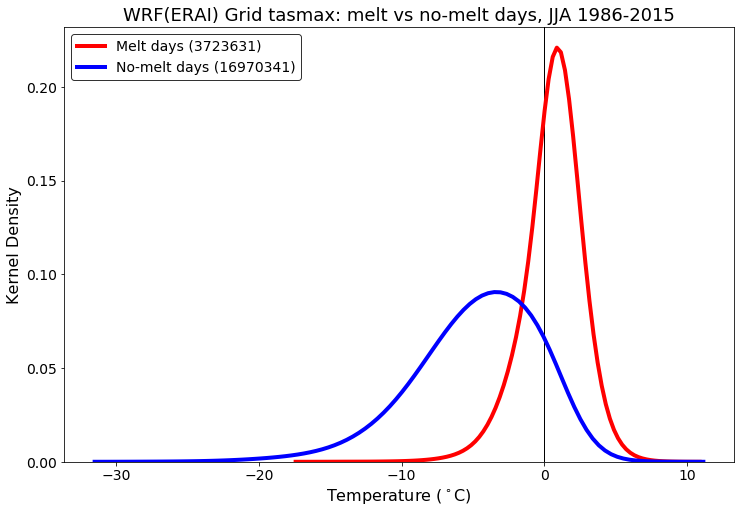

In [35]:
# make KDE plot
tStart = timer()
fig, ax = plt.subplots( figsize=(12,8))
plotData( tasm, bw, 'r' )
plotData( tasnm, bw, 'b' )

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Kernel Density'
if not site is None:
    title = "WRF(ERAI) "+site+" tasmax: melt vs no-melt days, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) Grid tasmax: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt days ('+str(len(tasm))+')', 'No-melt days ('+str(len(tasnm))+')' ]
annotatePlot( title, xlabel, ylabel, legend, None )
   
xmin, xmax = ax.get_xlim();

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

P.saveFigure2( "wrf_erai_tasmax_grid_kde_"+yrsHist+"_"+mms )

Create transition functions
----

In [36]:
# generate KDE's directly
tStart = timer()
if not restoreData:
    xs = np.arange(min(tasmax), max(tasmax), 0.1)
    Km = stats.gaussian_kde( tasm, bw_method=bw )
    Xm = np.array(Km(xs))
    Knm = stats.gaussian_kde( tasnm, bw_method=bw )
    Xnm = np.array(Knm(xs))

    # normalized versions to plot with the derived transition functions
    Xscale = max(max(Xm),max(Xnm))
    XmNrm = Xm / Xscale
    XnmNrm = Xnm / Xscale

tEnd = timer()
tElap = tEnd - tStart
print "Elapsed: %d seconds" % tElap

Elapsed: 0 seconds


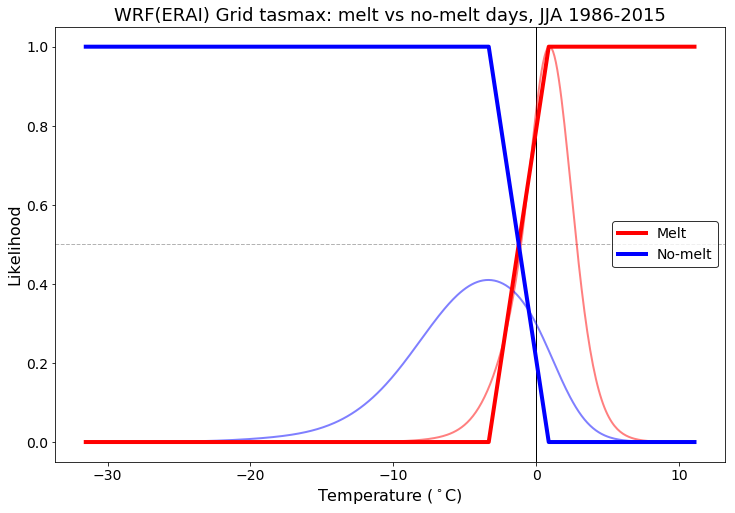

In [37]:
# make plot of transition functions
if not restoreData:
    Pm, Pnm, xLwr, xUpr, m, b = transitionFN( xs, Xm, Xnm, 0 )
    print "Lower break = %.1f, Upper break = %.1f" % ( xLwr, xUpr )
    print "slope = %.2f, intercept = %.2f" % ( m, b )

# xMid = (xUpr + xLwr) / 2.
# yMid = m*xMid + b
# print xMid, yMid

fig, ax = plt.subplots( figsize=(12,8))

plt.plot( xs, XmNrm,  color = 'r', linewidth = linewidth/2, alpha = 0.5 )
plt.plot( xs, XnmNrm, color = 'b', linewidth = linewidth/2, alpha = 0.5 )

plt.plot(xs, Pm, color='r', linewidth = linewidth)
plt.plot(xs, Pnm, color='b', linewidth = linewidth)
# plt.plot( xMid, yMid, 'ro', markersize = 20)

xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood'
if not site is None:
    title = "WRF(ERAI) "+site+" tasmax: melt vs no-melt, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) Grid tasmax: melt vs no-melt days, "+mms+" "+yrsHist
legend = [ 'Melt', 'No-melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

# ax.set_xlim( xmin, xmax );

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees
plt.axhline(y=0.5, linewidth=1, color='0.7', linestyle='--', zorder = 0.1);  # show pCrit (default=0.5)

P.saveFigure2( "wrf_erai_tas_grid_kde_trans_"+yrsHist+"_"+mms )

Simple probability transition curve
---

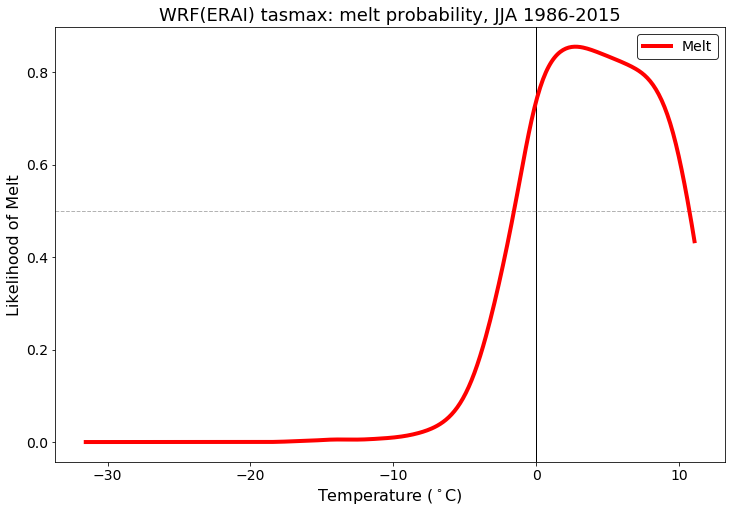

In [38]:
if not restoreData:
    Xsum = XmNrm + XnmNrm
    Z = XmNrm / Xsum   # normalized fraction of melt likelihood

fig, ax = plt.subplots( figsize=(12,8))
plt.plot(xs, Z, color='r', linewidth = linewidth)
xlabel = 'Temperature ($^\circ$C)'
ylabel = 'Likelihood of Melt'
if not site is None:
    title = "WRF(ERAI) "+site+" tasmax: melt probability, "+mms+" "+yrsHist
else:
    title = "WRF(ERAI) tasmax: melt probability, "+mms+" "+yrsHist
legend = [ 'Melt' ]
annotatePlot( title, xlabel, ylabel, legend, None )

plt.axvline(linewidth=1, color='k', zorder = 0.1);

plt.axvline(linewidth=1, color='k', zorder = 0.1);  # show zero degrees
plt.axhline(y=0.5, linewidth=1, color='0.7', linestyle='--', zorder = 0.1);  # show pCrit (default=0.5)

In [39]:
if saveData:
    saveState( npFN )
else:
    print "Not saving state variables"

Not saving state variables


Remaining code is NOT used...
===

In [40]:
# Alternative way to plot:  do the generated series instead of using kdeplot()
# fig, ax = plt.subplots( figsize=(12,8))
# plt.plot(xs, Xm, linewidth=linewidth)
# plt.plot(xs, Xnm, linewidth=linewidth)
# addLegend( ax, [ 'Melt days', 'No-melt days' ] )
# xmin, xmax = ax.get_xlim();

# if not site is None:
#     plt.title("KDE WRF(ERAI) "+site+" tasmax: melt vs no-melt days, "+mms+" "+yrsHist, fontsize=16);
# else:
#     plt.title("KDE WRF(ERAI) tasmax: melt vs no-melt days, "+mms+" "+yrsHist, fontsize=16);